In [1]:
import os
import sys

up1 = os.path.abspath('..') 
sys.path.insert(0, up1)
from network import getSimpleMotionModelOnly, getKerasCifarMotionModelOnly
from keras_data_generator.ucf101_datagenerator.optical_flow_data_gen import DataGenerator
import csv
from keras.optimizers import SGD

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
params = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 32,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
           'validation' : False}


import re 

def get_train_data(listPath):
# load Id list and labels 

    train_list = list()

    with open(listPath, 'r') as f:
        reader = csv.reader(f)
        train_list = list(reader)

        labels = [int(label[0].split(' ')[1]) for label in train_list ]
    IDs = [label[0].split(' ')[0] for label in train_list ]
    # IDs
    IDs = [id.split('/')[1].rstrip('.avi') for id in IDs ]

    labels = dict(zip(IDs, labels))
    return (IDs, labels)

def get_test_data(listPath, classIndexPath):
# load Id list and labels 
    
    train_list = None
    class_labels = None
    with open(listPath, 'r') as f:
        reader = csv.reader(f)
        train_list = list(reader)

    with open(classIndexPath, 'r') as f:
        reader = csv.reader(f)
        class_labels = list(reader)
    
    ucf_class = [c[0].split(' ')[1] for c in class_labels]
    ucf_labels = [int(c[0].split(' ')[0]) for c in class_labels]
    
    ucf_dict = dict(zip(ucf_class, ucf_labels))
    
    IDs = [id_[0].split('/')[1].rstrip('.avi') for id_ in train_list ]
    labels = dict()
    
    p = re.compile('v\_([a-zA-Z]*)\_g\w*') 
    for id_ in IDs:
        f = p.match(id_)
        if f:
            labels[id_] = ucf_dict[f[1]]
        else:
            Exception("failed")
    return IDs, labels

id_labels_train = get_train_data('../keras_data_generator/ucf101_splits/trainlist01.txt')
labels = id_labels_train[1]
id_test = get_test_data('../keras_data_generator/ucf101_splits/testlist01.txt', \
                       '../keras_data_generator/ucf101_splits/classInd.txt')

training_generator = DataGenerator(*id_labels_train, **params)

params['validation'] = True
validation_generator = DataGenerator(id_test[0], id_test[1], **params)


In [3]:

simple_model= getSimpleMotionModelOnly(input_shape=(224,224,2), n_classes=101)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      608       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
__________

In [4]:


simple_model.load_weights('.motion_model_weights.h5')
mypotim = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
simple_model.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [6]:
mod1 = simple_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=20,
                    verbose=1)

Epoch 1/20
298/298 [==============================] - 38s 127ms/step - loss: 3.6101 - acc: 0.1597 - val_loss: 3.6614 - val_acc: 0.1658
Epoch 2/20
298/298 [==============================] - 38s 127ms/step - loss: 3.6204 - acc: 0.1570 - val_loss: 3.6278 - val_acc: 0.1645
Epoch 3/20
298/298 [==============================] - 42s 143ms/step - loss: 3.6023 - acc: 0.1643 - val_loss: 3.6785 - val_acc: 0.1557
Epoch 4/20
298/298 [==============================] - 39s 132ms/step - loss: 3.5951 - acc: 0.1593 - val_loss: 3.6218 - val_acc: 0.1523
Epoch 5/20
298/298 [==============================] - 41s 138ms/step - loss: 3.5772 - acc: 0.1604 - val_loss: 3.6389 - val_acc: 0.1499
Epoch 6/20
298/298 [==============================] - 42s 139ms/step - loss: 3.5497 - acc: 0.1710 - val_loss: 3.6147 - val_acc: 0.1565
Epoch 7/20
298/298 [==============================] - 39s 132ms/step - loss: 3.5512 - acc: 0.1721 - val_loss: 3.6649 - val_acc: 0.1541
Epoch 8/20
298/298 [==============================] - 4

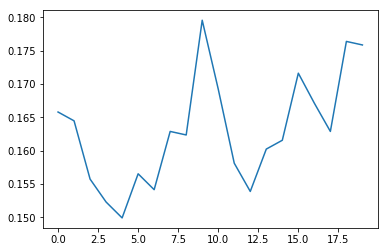

In [9]:
from matplotlib import pyplot as  plt
plt.plot(mod1.history['val_acc'])

In [13]:
simple_model.save_weights('.motion_model_weights2.h5')

In [16]:

simple_model2= getSimpleMotionModelOnly(input_shape=(224,224,2), n_classes=101)
simple_model2.load_weights('.motion_model_weights2.h5')
mypotim = SGD(lr=0.5e-2, decay=1e-6, momentum=0.9, nesterov=True)
simple_model2.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 222, 222, 32)      608       
_________________________________________________________________
activation_16 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_17 (Activation)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 52, 52, 64)        18496     
__________

In [17]:
mod2 = simple_model2.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=20,
                    verbose=1)

Epoch 1/20
298/298 [==============================] - 39s 132ms/step - loss: 3.3471 - acc: 0.2083 - val_loss: 3.5233 - val_acc: 0.1854
Epoch 2/20
298/298 [==============================] - 39s 130ms/step - loss: 3.3501 - acc: 0.2113 - val_loss: 3.4791 - val_acc: 0.1880
Epoch 3/20
298/298 [==============================] - 40s 135ms/step - loss: 3.3153 - acc: 0.2139 - val_loss: 3.4635 - val_acc: 0.1936
Epoch 4/20
298/298 [==============================] - 36s 121ms/step - loss: 3.2679 - acc: 0.2208 - val_loss: 3.4729 - val_acc: 0.1920
Epoch 5/20
298/298 [==============================] - 41s 136ms/step - loss: 3.2807 - acc: 0.2159 - val_loss: 3.4422 - val_acc: 0.2023
Epoch 6/20
298/298 [==============================] - 37s 124ms/step - loss: 3.2770 - acc: 0.2280 - val_loss: 3.4900 - val_acc: 0.1962
Epoch 7/20
298/298 [==============================] - 42s 140ms/step - loss: 3.2424 - acc: 0.2282 - val_loss: 3.4578 - val_acc: 0.1949
Epoch 8/20
298/298 [==============================] - 3

In [19]:
simple_model2.save_weights('.motion_model_weights2.h5')

In [3]:

simple_model3= getKerasCifarMotionModelOnly(input_shape=(224,224,2), n_classes=101, printmod=0)

In [4]:
mypotim = SGD(lr=0.5e-2, decay=1e-6, momentum=0.9, nesterov=True)
simple_model3.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [5]:
mod3 = simple_model3.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=20,
                    verbose=1)

Epoch 1/20
298/298 [==============================] - 102s 342ms/step - loss: 4.5377 - acc: 0.0261 - val_loss: 4.4764 - val_acc: 0.0305
Epoch 2/20
298/298 [==============================] - 98s 329ms/step - loss: 4.4209 - acc: 0.0411 - val_loss: 4.3803 - val_acc: 0.0543
Epoch 3/20
298/298 [==============================] - 99s 332ms/step - loss: 4.3286 - acc: 0.0519 - val_loss: 4.3340 - val_acc: 0.0596
Epoch 4/20
298/298 [==============================] - 98s 330ms/step - loss: 4.2636 - acc: 0.0640 - val_loss: 4.2953 - val_acc: 0.0662
Epoch 5/20
298/298 [==============================] - 98s 330ms/step - loss: 4.1974 - acc: 0.0829 - val_loss: 4.2218 - val_acc: 0.0773
Epoch 6/20
298/298 [==============================] - 98s 330ms/step - loss: 4.1353 - acc: 0.0844 - val_loss: 4.2114 - val_acc: 0.0763
Epoch 7/20
298/298 [==============================] - 99s 332ms/step - loss: 4.0610 - acc: 0.0947 - val_loss: 4.1665 - val_acc: 0.0834
Epoch 8/20
298/298 [==============================] - 

In [7]:
simple_model3.save_weights('.motion_model_cifar_weights1.h5')

In [8]:
mod4 = simple_model3.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=20,
                    verbose=1)

Epoch 1/20
298/298 [==============================] - 98s 328ms/step - loss: 3.3208 - acc: 0.2279 - val_loss: 3.6958 - val_acc: 0.1557
Epoch 2/20
298/298 [==============================] - 98s 328ms/step - loss: 3.2899 - acc: 0.2398 - val_loss: 3.6598 - val_acc: 0.1660
Epoch 3/20
298/298 [==============================] - 98s 328ms/step - loss: 3.2320 - acc: 0.2457 - val_loss: 3.5929 - val_acc: 0.1706
Epoch 4/20
298/298 [==============================] - 98s 329ms/step - loss: 3.2187 - acc: 0.2493 - val_loss: 3.6226 - val_acc: 0.1698
Epoch 5/20
298/298 [==============================] - 98s 329ms/step - loss: 3.1601 - acc: 0.2583 - val_loss: 3.6931 - val_acc: 0.1690
Epoch 6/20
298/298 [==============================] - 98s 329ms/step - loss: 3.1243 - acc: 0.2656 - val_loss: 3.5598 - val_acc: 0.1894
Epoch 7/20
298/298 [==============================] - 98s 330ms/step - loss: 3.0570 - acc: 0.2797 - val_loss: 3.5331 - val_acc: 0.1891
Epoch 8/20
298/298 [==============================] - 9

In [9]:
simple_model3.save_weights('.motion_model_cifar_weights2.h5')

In [10]:
simple_model4= getKerasCifarMotionModelOnly(input_shape=(224,224,2), n_classes=101, printmod=0)
simple_model4.load_weights('.motion_model_cifar_weights2.h5')
mypotim = SGD(lr=1e-4, momentum=0.9)
simple_model4.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [11]:
mod4 = simple_model4.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=10,
                    verbose=1)

Epoch 1/10
298/298 [==============================] - 95s 318ms/step - loss: 2.6589 - acc: 0.3644 - val_loss: 3.3678 - val_acc: 0.2185
Epoch 2/10
298/298 [==============================] - 94s 316ms/step - loss: 2.6113 - acc: 0.3630 - val_loss: 3.3046 - val_acc: 0.2381
Epoch 3/10
298/298 [==============================] - 95s 317ms/step - loss: 2.5865 - acc: 0.3743 - val_loss: 3.3099 - val_acc: 0.2272
Epoch 4/10
298/298 [==============================] - 94s 316ms/step - loss: 2.5586 - acc: 0.3786 - val_loss: 3.3204 - val_acc: 0.2325
Epoch 5/10
298/298 [==============================] - 94s 316ms/step - loss: 2.5540 - acc: 0.3810 - val_loss: 3.3012 - val_acc: 0.2275
Epoch 6/10
298/298 [==============================] - 94s 316ms/step - loss: 2.5369 - acc: 0.3873 - val_loss: 3.3231 - val_acc: 0.2352
Epoch 7/10
298/298 [==============================] - 94s 316ms/step - loss: 2.5200 - acc: 0.3948 - val_loss: 3.2953 - val_acc: 0.2373
Epoch 8/10
298/298 [==============================] - 9

In [12]:
mod4 = simple_model4.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=20,
                    verbose=1)

Epoch 1/20
298/298 [==============================] - 94s 315ms/step - loss: 2.4983 - acc: 0.3934 - val_loss: 3.2366 - val_acc: 0.2481
Epoch 2/20
298/298 [==============================] - 94s 315ms/step - loss: 2.4811 - acc: 0.3990 - val_loss: 3.3063 - val_acc: 0.2365
Epoch 3/20
298/298 [==============================] - 95s 317ms/step - loss: 2.4982 - acc: 0.3919 - val_loss: 3.3036 - val_acc: 0.2320
Epoch 4/20
298/298 [==============================] - 94s 315ms/step - loss: 2.4876 - acc: 0.3952 - val_loss: 3.2559 - val_acc: 0.2344
Epoch 5/20
298/298 [==============================] - 95s 319ms/step - loss: 2.4465 - acc: 0.4020 - val_loss: 3.2649 - val_acc: 0.2428
Epoch 6/20
298/298 [==============================] - 94s 316ms/step - loss: 2.4760 - acc: 0.4011 - val_loss: 3.2970 - val_acc: 0.2331
Epoch 7/20
298/298 [==============================] - 94s 316ms/step - loss: 2.4998 - acc: 0.3946 - val_loss: 3.2844 - val_acc: 0.2357
Epoch 8/20
298/298 [==============================] - 9

In [13]:
simple_model4.save_weights('.motion_model_cifar_weights3.h5')

In [3]:
params = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 32,
          'n_frames': 4,
          'n_frequency': 5,
          'shuffle': True, 
           'validation' : False}

training_generator = DataGenerator(*id_labels_train, **params)

params['validation'] = True
validation_generator = DataGenerator(id_test[0], id_test[1], **params)


In [24]:
simple_model5= getKerasCifarMotionModelOnly(input_shape=(224,224,8), n_classes=101, printmod=0)
mypotim = SGD(lr=0.5e-2, momentum=0.9)
simple_model5.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [25]:
mod5 = simple_model5.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=1,
                    verbose=1)

Epoch 1/1
298/298 [==============================] - 172s 578ms/step - loss: 4.5545 - acc: 0.0275 - val_loss: 4.5115 - val_acc: 0.0381


In [26]:
mod5 = simple_model5.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=20,
                    verbose=1)

Epoch 1/20
298/298 [==============================] - 169s 569ms/step - loss: 4.4389 - acc: 0.0487 - val_loss: 4.4072 - val_acc: 0.0625
Epoch 2/20
298/298 [==============================] - 168s 564ms/step - loss: 4.2851 - acc: 0.0708 - val_loss: 4.2238 - val_acc: 0.0903
Epoch 3/20
298/298 [==============================] - 165s 555ms/step - loss: 4.0842 - acc: 0.0948 - val_loss: 4.0648 - val_acc: 0.1033
Epoch 4/20
298/298 [==============================] - 167s 561ms/step - loss: 3.9419 - acc: 0.1201 - val_loss: 3.9756 - val_acc: 0.1181
Epoch 5/20
298/298 [==============================] - 169s 568ms/step - loss: 3.8272 - acc: 0.1349 - val_loss: 3.9921 - val_acc: 0.1020
Epoch 6/20
298/298 [==============================] - 169s 568ms/step - loss: 3.7420 - acc: 0.1544 - val_loss: 3.8724 - val_acc: 0.1284
Epoch 7/20
298/298 [==============================] - 166s 558ms/step - loss: 3.6327 - acc: 0.1697 - val_loss: 3.8204 - val_acc: 0.1425
Epoch 8/20
298/298 [============================

In [28]:
mod6 = simple_model5.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=20,
                    verbose=1)

Epoch 1/20
298/298 [==============================] - 163s 546ms/step - loss: 2.8195 - acc: 0.3295 - val_loss: 3.6423 - val_acc: 0.1806
Epoch 2/20
298/298 [==============================] - 161s 542ms/step - loss: 2.7415 - acc: 0.3407 - val_loss: 3.6359 - val_acc: 0.1761
Epoch 3/20
298/298 [==============================] - 162s 543ms/step - loss: 2.7321 - acc: 0.3505 - val_loss: 3.6767 - val_acc: 0.1756
Epoch 4/20
298/298 [==============================] - 161s 539ms/step - loss: 2.6913 - acc: 0.3603 - val_loss: 3.5874 - val_acc: 0.1909
Epoch 5/20
298/298 [==============================] - 161s 542ms/step - loss: 2.6158 - acc: 0.3762 - val_loss: 3.5724 - val_acc: 0.1894
Epoch 6/20
298/298 [==============================] - 161s 540ms/step - loss: 2.5942 - acc: 0.3823 - val_loss: 3.6348 - val_acc: 0.1947
Epoch 7/20
298/298 [==============================] - 164s 551ms/step - loss: 2.5399 - acc: 0.3868 - val_loss: 3.6031 - val_acc: 0.2010
Epoch 8/20
298/298 [============================

In [30]:
simple_model5.save_weights('.motion_model_cifar_c4_weights2.h5')

In [4]:
simple_model5= getKerasCifarMotionModelOnly(input_shape=(224,224,8), n_classes=101, printmod=0)
simple_model5.load_weights('.motion_model_cifar_c4_weights2.h5')
mypotim = SGD(lr=1e-4, momentum=0.9)
simple_model5.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [5]:
mod6 = simple_model5.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=10,
                    verbose=1)

Epoch 1/10
298/298 [==============================] - 163s 546ms/step - loss: 1.9861 - acc: 0.5089 - val_loss: 3.4546 - val_acc: 0.2341
Epoch 2/10
298/298 [==============================] - 211s 707ms/step - loss: 1.9622 - acc: 0.5082 - val_loss: 3.4572 - val_acc: 0.2381
Epoch 3/10
298/298 [==============================] - 232s 778ms/step - loss: 1.9621 - acc: 0.5076 - val_loss: 3.4113 - val_acc: 0.2434
Epoch 4/10
298/298 [==============================] - 274s 918ms/step - loss: 1.9239 - acc: 0.5072 - val_loss: 3.4596 - val_acc: 0.2325
Epoch 5/10
298/298 [==============================] - 251s 843ms/step - loss: 1.8927 - acc: 0.5224 - val_loss: 3.4602 - val_acc: 0.2418
Epoch 6/10
298/298 [==============================] - 262s 879ms/step - loss: 1.8838 - acc: 0.5273 - val_loss: 3.4369 - val_acc: 0.2463
Epoch 7/10
298/298 [==============================] - 288s 967ms/step - loss: 1.8920 - acc: 0.5266 - val_loss: 3.4296 - val_acc: 0.2503
Epoch 8/10
298/298 [============================

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.549263). Check your callbacks.
  % delta_t_median)


298/298 [==============================] - 341s 1s/step - loss: 1.8424 - acc: 0.5337 - val_loss: 3.4166 - val_acc: 0.2442


In [6]:
simple_model5.save_weights('.motion_model_cifar_c4_weights3.h5')